## convnext train & test
- 캐글의 https://www.kaggle.com/datasets/gpiosenka/sports-classification 데이터를 이용해서 convnext 훈련 및 성능 테스트

In [21]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
DATA_DIR = "/kaggle/input/sports-classification"

train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")

In [25]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_tfms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_tfms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [26]:
num_classes = len(train_dataset.classes)

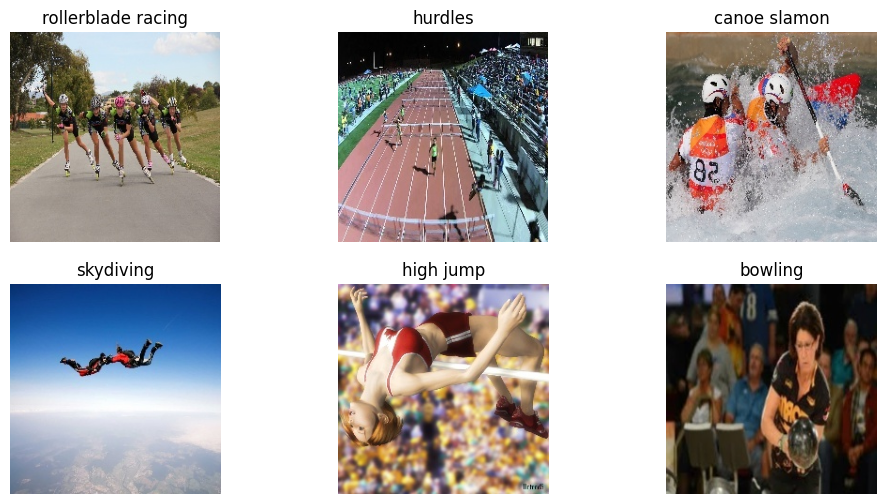

In [10]:
# 데이터 랜덤 시각화
def show_random_images(dataset, n=6):
    idxs = random.sample(range(len(dataset)), n)
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
        img = img.clamp(0,1)
        
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(train_dataset.classes[label])
        plt.axis("off")
    plt.show()

show_random_images(train_dataset)

In [12]:
model = models.convnext_tiny(pretrained=True)

model.classifier[2] = nn.Linear(
    model.classifier[2].in_features,
    num_classes
)

model = model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [14]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss/len(train_loader):.4f}")
        

[Epoch 1] Loss: 0.9087
[Epoch 2] Loss: 0.1409
[Epoch 3] Loss: 0.0992
[Epoch 4] Loss: 0.0705
[Epoch 5] Loss: 0.0942
[Epoch 6] Loss: 0.0809
[Epoch 7] Loss: 0.0574
[Epoch 8] Loss: 0.0650
[Epoch 9] Loss: 0.0657
[Epoch 10] Loss: 0.0511


In [15]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


In [16]:
acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

Test Accuracy: 0.95


In [17]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=train_dataset.classes
))

                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      0.80      0.89         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       0.83      1.00      0.91         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       0.83      1.00      0.91         5
              bowling       1.00      0.80      0.89  

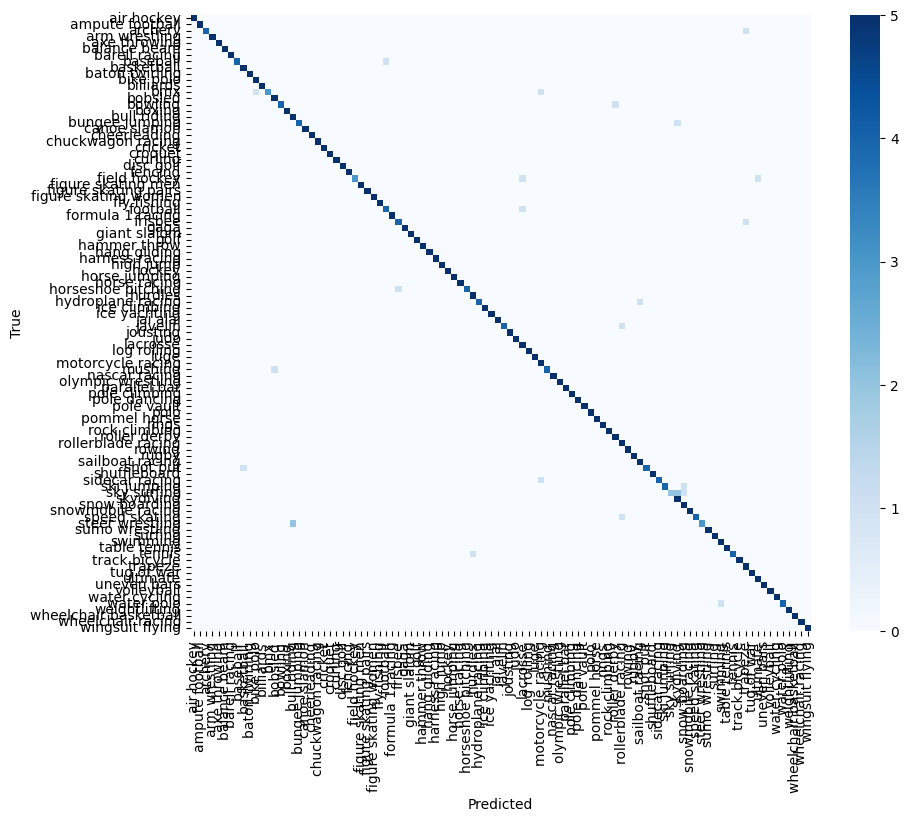

In [18]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [19]:
SAVE_PATH = "convnext_tiny_sports.pth"

torch.save(model.state_dict(), SAVE_PATH)

In [34]:
from PIL import Image

test_root = "/kaggle/input/sports-classification/test"

# 모든 이미지 경로 수집
all_images = []
for cls in os.listdir(test_root):
    cls_path = os.path.join(test_root, cls)
    if os.path.isdir(cls_path):
        for img in os.listdir(cls_path):
            all_images.append(os.path.join(cls_path, img))

img_path = random.choice(all_images)

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

image = Image.open(img_path).convert("RGB")
input_tensor = test_tfms(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

pred_class = train_dataset.classes[pred_idx]
pred_conf  = probs[0][pred_idx].item()

print(pred_class, pred_conf)

ultimate 0.9997238516807556
